In [1]:
# We load the competition data

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)
from sklearn.feature_selection import (
    mutual_info_regression
)
from sklearn.inspection import (
    permutation_importance
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Primer análisis

https://www.kaggle.com/code/les1781/listening-time-prediction-playground-series-s5-e4

In [3]:
# We load the data

listening_new = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv", index_col="id")

# Data wrangling

In [4]:
# We check for null values

null_values = (
    pd.DataFrame(
        {f"Amount of Null Data": listening_new.isnull().sum(), 
         "Percentage of Null Data" : (
             listening_new.isnull().sum()) / (len(listening_new)) * (100)
        }))

null_values.style.background_gradient(cmap="Greens")

,Amount of Null Data,Percentage of Null Data
Podcast_Name,0,0.000000
Episode_Title,0,0.000000
Episode_Length_minutes,87093,11.612400
Genre,0,0.000000
Host_Popularity_percentage,0,0.000000
Publication_Day,0,0.000000
Publication_Time,0,0.000000
Guest_Popularity_percentage,146030,19.470667
Number_of_Ads,1,0.000133
Episode_Sentiment,0,0.000000


In [5]:
# We fill null values with the mean groupby Podcast

listening_new["Episode_Length_minutes"] = (listening_new["Episode_Length_minutes"].fillna(
    listening_new.groupby("Podcast_Name")["Episode_Length_minutes"].transform("mean")
))
print(
    "Number of null values: ", listening_new["Episode_Length_minutes"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Episode_Length_minutes"].value_counts(normalize=True)
)

Number of null values:  0 

 Distribution of values: 
 Episode_Length_minutes
64.307741    0.003676
67.117406    0.003409
63.733542    0.003273
62.711968    0.003211
62.850526    0.003109
               ...   
44.000846    0.000001
8.438445     0.000001
86.442500    0.000001
77.137000    0.000001
62.167294    0.000001
Name: proportion, Length: 12316, dtype: float64


In [6]:
# We replace the erroneous values with the mode of the Podcasts

listening_new["Number_of_Ads"] = (listening_new["Number_of_Ads"].apply(lambda x: np.NaN if x>3 else x))

listening_new["Number_of_Ads"] = (listening_new["Number_of_Ads"].fillna(
        listening_new.groupby("Podcast_Name")["Number_of_Ads"].transform(lambda v: v.mode()[0])))

print(
    "Number of null values: ", listening_new["Number_of_Ads"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Number_of_Ads"].value_counts()
)

Number of null values:  0 

 Distribution of values: 
 Number_of_Ads
0.0    217597
1.0    214074
3.0    160173
2.0    158156
Name: count, dtype: int64


In [7]:
# We replace the erroneous values

listening_new["Host_Popularity_percentage"] = np.where(
    listening_new["Host_Popularity_percentage"] > 100, 100, listening_new["Host_Popularity_percentage"]
).round(decimals=2)

print(
    "Number of Unique values: ", listening_new["Host_Popularity_percentage"].nunique(), "\n",
    "Distribution of values: \n", listening_new["Host_Popularity_percentage"].value_counts(normalize=True)
)

Number of Unique values:  8007 
 Distribution of values: 
 Host_Popularity_percentage
38.68    0.000747
26.72    0.000697
56.29    0.000653
30.14    0.000593
31.57    0.000585
           ...   
1.77     0.000003
1.30     0.000001
39.18    0.000001
1.73     0.000001
1.47     0.000001
Name: proportion, Length: 8007, dtype: float64


In [8]:
# We replace the erroneous values

listening_new["Guest_Popularity_percentage"] = np.where(
    listening_new["Guest_Popularity_percentage"] > 100, 100, listening_new["Guest_Popularity_percentage"]
)

# We fill null values with the mean groupby Podcast

listening_new["Guest_Popularity_percentage"] = (
    listening_new["Guest_Popularity_percentage"].fillna(
        listening_new.groupby("Podcast_Name")["Guest_Popularity_percentage"].transform("mean")
    )
).round(decimals=2)

print(
    "Number of Unique values: ", listening_new["Guest_Popularity_percentage"].nunique(), "\n",
    "Number of null values: ", listening_new["Guest_Popularity_percentage"].isnull().sum(), "\n\n",
    "Distribution of values: \n", listening_new["Guest_Popularity_percentage"].value_counts(normalize=True)
)

Number of Unique values:  9991 
 Number of null values:  0 

 Distribution of values: 
 Guest_Popularity_percentage
52.24    0.009640
51.27    0.008721
51.88    0.006383
52.60    0.006055
52.63    0.005424
           ...   
42.36    0.000001
59.65    0.000001
3.88     0.000001
49.24    0.000001
11.60    0.000001
Name: proportion, Length: 9991, dtype: float64


In [9]:
# We changed the format for more efficient memory usage

listening_new[listening_new.select_dtypes(["object"]).columns] = (
    listening_new.select_dtypes(["object"]).apply(
        lambda x: x.astype("category"))
)

In [10]:
listening_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 750000 non-null  category
 1   Episode_Title                750000 non-null  category
 2   Episode_Length_minutes       750000 non-null  float64 
 3   Genre                        750000 non-null  category
 4   Host_Popularity_percentage   750000 non-null  float64 
 5   Publication_Day              750000 non-null  category
 6   Publication_Time             750000 non-null  category
 7   Guest_Popularity_percentage  750000 non-null  float64 
 8   Number_of_Ads                750000 non-null  float64 
 9   Episode_Sentiment            750000 non-null  category
 10  Listening_Time_minutes       750000 non-null  float64 
dtypes: category(6), float64(5)
memory usage: 38.6 MB


# Data preprocessing

In [11]:
listening_end = listening_new.copy()

In [12]:
# We map the variables and change the format

eps_order = {"Negative" : 0, "Neutral" : 1, "Positive" : 2}
listening_end["Episode_Sentiment"] = listening_end["Episode_Sentiment"].map(eps_order)
listening_end["Episode_Sentiment"] = listening_end["Episode_Sentiment"].astype("float64")

In [13]:
# We separate the categorical variables from the numerical ones

df_numerical = listening_end.select_dtypes(include="number")
df_categorical = listening_end.select_dtypes(include="category")

## Encode

In [14]:
# We apply OrdinalEncoder to the remaining categorical variables

enc = OrdinalEncoder(categories="auto").set_output(transform="pandas")

enc_data = enc.fit_transform(df_categorical)

df_listening = pd.concat([enc_data, df_numerical], axis=1)

In [15]:
df_listening.corr().style.background_gradient(cmap='Greens')

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
Podcast_Name,1.000000,0.006669,0.188052,0.003117,-0.002328,0.006335,-0.002424,-0.004750,0.008955,0.003115,0.004346
Episode_Title,0.006669,1.000000,0.006847,0.001100,-0.000304,-0.019925,0.020208,0.034565,0.006395,-0.004845,-0.020842
Genre,0.188052,0.006847,1.000000,0.003305,-0.001329,-0.000452,-0.008807,0.007005,-0.003429,-0.001588,0.004940
Publication_Day,0.003117,0.001100,0.003305,1.000000,-0.000860,0.006598,-0.003698,0.000398,0.004986,0.004594,0.004030
Publication_Time,-0.002328,-0.000304,-0.001329,-0.000860,1.000000,0.009908,0.000182,-0.005023,-0.006727,0.008923,0.013225
Episode_Length_minutes,0.006335,-0.019925,-0.000452,0.006598,0.009908,1.000000,0.022221,-0.008353,-0.054821,0.024724,0.866202
Host_Popularity_percentage,-0.002424,0.020208,-0.008807,-0.003698,0.000182,0.022221,1.000000,0.020061,-0.017831,0.007063,0.050854
Guest_Popularity_percentage,-0.004750,0.034565,0.007005,0.000398,-0.005023,-0.008353,0.020061,1.000000,0.007659,0.000488,-0.014399
Number_of_Ads,0.008955,0.006395,-0.003429,0.004986,-0.006727,-0.054821,-0.017831,0.007659,1.000000,-0.020627,-0.124201
Episode_Sentiment,0.003115,-0.004845,-0.001588,0.004594,0.008923,0.024724,0.007063,0.000488,-0.020627,1.000000,0.039470


## Scaling

In [16]:
# We separate the target variable from the features and data to scale

x_listening = df_listening.drop(columns="Listening_Time_minutes")
y_listening = df_listening["Listening_Time_minutes"]

In [17]:
# Numerical variables to scale

df_numeric = x_listening[[
    "Episode_Length_minutes",
    "Host_Popularity_percentage",
    "Guest_Popularity_percentage"
]]

scaler = StandardScaler().set_output(transform="pandas")
scale_num = scaler.fit_transform(df_numeric)

# We create a df with the remaining variables

df_rest = x_listening.drop(
    columns=["Episode_Length_minutes",
             "Host_Popularity_percentage",
             "Guest_Popularity_percentage"]
)

# We concatenate the dataframes

x_end = pd.concat([df_rest, scale_num], axis=1)

In [18]:
x_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Podcast_Name,750000.0,2.351573e+01,14.137577,0.000000,11.000000,23.000000,37.000000,47.000000
Episode_Title,750000.0,5.028600e+01,28.186681,0.000000,26.000000,51.000000,74.000000,99.000000
Genre,750000.0,4.648788e+00,2.963073,0.000000,2.000000,5.000000,7.000000,9.000000
Publication_Day,750000.0,2.962776e+00,1.997399,0.000000,1.000000,3.000000,5.000000,6.000000
Publication_Time,750000.0,1.522868e+00,1.119361,0.000000,1.000000,1.000000,3.000000,3.000000
Number_of_Ads,750000.0,1.347873e+00,1.110966,0.000000,0.000000,1.000000,2.000000,3.000000
Episode_Sentiment,750000.0,9.979693e-01,0.815440,0.000000,0.000000,1.000000,2.000000,2.000000
Episode_Length_minutes,750000.0,2.563828e-16,1.000001,-2.080627,-0.809072,-0.002546,0.832465,8.410505
Host_Popularity_percentage,750000.0,-2.175208e-16,1.000001,-2.560290,-0.894076,0.008330,0.860018,1.754991
Guest_Popularity_percentage,750000.0,-5.623709e-17,1.000001,-2.045665,-0.692546,0.007707,0.736551,1.870743


## Feature Selection

In [19]:
mi_scores = mutual_info_regression(x_end, y_listening)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_end.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

Episode_Length_minutes         2.013859
Host_Popularity_percentage     0.762258
Episode_Title                  0.684167
Guest_Popularity_percentage    0.644529
Podcast_Name                   0.417473
Publication_Day                0.243235
Number_of_Ads                  0.238481
Genre                          0.199871
Publication_Time               0.174842
Episode_Sentiment              0.142919
Name: MI Scores, dtype: float64

Basándome en la correlación y la importancia mutua me desprendo de algunas variables. Probar otras combinaciones y métodos de selección de variables.

In [20]:
x_end = x_end.drop(columns=["Podcast_Name", "Episode_Title"])

In [21]:
x_end.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Genre                        750000 non-null  float64
 1   Publication_Day              750000 non-null  float64
 2   Publication_Time             750000 non-null  float64
 3   Number_of_Ads                750000 non-null  float64
 4   Episode_Sentiment            750000 non-null  float64
 5   Episode_Length_minutes       750000 non-null  float64
 6   Host_Popularity_percentage   750000 non-null  float64
 7   Guest_Popularity_percentage  750000 non-null  float64
dtypes: float64(8)
memory usage: 51.5 MB


# Model Selection

In [22]:
# We separate the data into training and validation sets

x_train, x_val, y_train, y_val = (
    train_test_split(
        x_end, y_listening, test_size=0.3, random_state=42
    )
)

In [23]:
# Create the KFold object

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

## XGBRegressor

In [24]:
# We create the model instance

xgbr = XGBRegressor()
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [25]:
# We establish the parameters to test

xgbr_param_grid = {
    "gamma" : [0.1, 0.5, 0.8, 0, 1],
    "max_depth" : [3, 4, 5, 6, 7],
    "learning_rate" : [0.2, 0.1, 0.01, 0.001],
    "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "n_estimators" : [50, 100, 150, 200]
}

xgbr_grid = RandomizedSearchCV(
    xgbr,
    xgbr_param_grid,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    return_train_score=True
)

xgbr_search = xgbr_grid.fit(x_train, y_train)

print(
    f'Parameters: {xgbr_search.best_params_}\nScore: {xgbr_search.best_score_}'
)

Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.8}
Score: -13.14409672360694


In [26]:
# We evaluate the performance after an initial optimization

y_pred_xgbr = xgbr_search.best_estimator_.predict(x_val)

r2_xgbr = r2_score(y_val, y_pred_xgbr)

rmse_xgbr = np.sqrt(mean_squared_error(y_val, y_pred_xgbr))

print(f"XGBRegressor optimization\n\nR-squared score: {r2_xgbr}\nRMSE: {rmse_xgbr}")

XGBRegressor optimization

R-squared score: 0.765933936791023
RMSE: 13.119810835699889


# Final Model

In [27]:
final_model = xgbr_search.best_estimator_

# We fit the best model

final_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.8, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
# We evaluate the performance of the final model

final_model_ypred = final_model.predict(x_val)

final_model_rmse = np.sqrt(mean_squared_error(y_val, final_model_ypred))

print("Final Model RMSE Score: %.3f" % final_model_rmse)

Final Model RMSE Score: 13.120


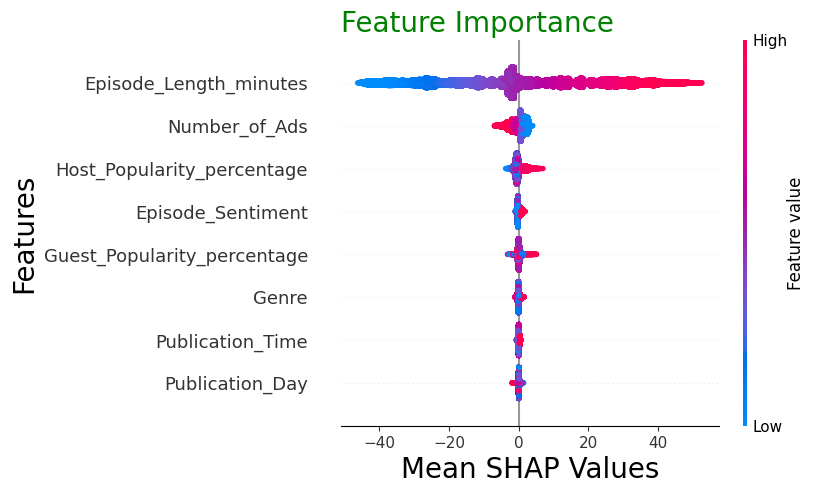

In [29]:
# We create an explainer for the best estimator

explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(x_val)

# we visualize the importance

fig = shap.summary_plot(
    shap_values,
    x_val,
    show=False
)
plt.title("Feature Importance", fontsize=20, color='g', loc='left')
plt.xlabel("Mean SHAP Values", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.show()

# Test data

In [30]:
# We load the test data

df_test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [31]:
df_test_new = df_test.copy()

In [32]:
# We check the null values

null_values_test = (
    pd.DataFrame(
        {f'Amount of Null Data' : df_test_new.isnull().sum(), 
         'Percentage of Null Data' : (
             df_test_new.isnull().sum()) / (len(df_test_new)) * (100)
        }
    ))

null_values_test.style.background_gradient(cmap='Greens')

,Amount of Null Data,Percentage of Null Data
id,0,0.000000
Podcast_Name,0,0.000000
Episode_Title,0,0.000000
Episode_Length_minutes,28736,11.494400
Genre,0,0.000000
Host_Popularity_percentage,0,0.000000
Publication_Day,0,0.000000
Publication_Time,0,0.000000
Guest_Popularity_percentage,48832,19.532800
Number_of_Ads,0,0.000000


In [33]:
# We filled in null values

df_test_new["Episode_Length_minutes"] = (df_test_new["Episode_Length_minutes"].fillna(
    df_test_new.groupby("Podcast_Name")["Episode_Length_minutes"].transform("mean")
))
df_test_new["Guest_Popularity_percentage"] = (df_test_new["Guest_Popularity_percentage"].fillna(
    df_test_new.groupby("Podcast_Name")["Guest_Popularity_percentage"].transform("mean")
))

# We replace the erroneous values

df_test_new["Number_of_Ads"] = (df_test_new["Number_of_Ads"].apply(lambda x: np.NaN if x>3 else x))
df_test_new["Number_of_Ads"] = (df_test_new["Number_of_Ads"].fillna(
    df_test_new.groupby("Podcast_Name")["Number_of_Ads"].transform(lambda v: v.mode()[0])
))
df_test_new["Host_Popularity_percentage"] = np.where(
    df_test_new["Host_Popularity_percentage"] > 100, 100, df_test_new["Host_Popularity_percentage"]
).round(decimals=2)
df_test_new["Guest_Popularity_percentage"] = np.where(
    df_test_new["Guest_Popularity_percentage"] > 100, 100, df_test_new["Guest_Popularity_percentage"]
).round(decimals=2)

In [34]:
# We start by removing the variables that we will not use

df_test_new = df_test_new.drop(columns=["id", "Podcast_Name", "Episode_Title"])

In [35]:
# We encode the categorical variables

df_test_new["Episode_Sentiment"] = df_test_new["Episode_Sentiment"].map(eps_order)
df_test_new["Episode_Sentiment"] = df_test_new["Episode_Sentiment"].astype("float64")

test_num = df_test_new.select_dtypes(include="number")
test_cat = df_test_new.select_dtypes(include="object")
test_enc = enc.fit_transform(test_cat)
test_encoded = pd.concat([test_enc, test_num[["Number_of_Ads", "Episode_Sentiment"]]], axis=1)

# We transform the data

test_num = test_num.drop(columns=["Number_of_Ads", "Episode_Sentiment"])
test_sca = scaler.transform(test_num)

# We concatenate the dataframes

test_end = pd.concat([test_encoded, test_sca], axis=1)

In [36]:
test_end.describe().T

,count,mean,std,min,25%,50%,75%,max
Genre,250000.0,4.641336,2.959436,0.000000,2.000000,5.000000,7.000000,9.000000e+00
Publication_Day,250000.0,2.962788,1.993649,0.000000,1.000000,3.000000,5.000000,6.000000e+00
Publication_Time,250000.0,1.522652,1.118540,0.000000,1.000000,1.000000,3.000000,3.000000e+00
Number_of_Ads,250000.0,1.347248,1.112669,0.000000,0.000000,1.000000,2.000000,3.000000e+00
Episode_Sentiment,250000.0,0.997236,0.815666,0.000000,0.000000,1.000000,2.000000,2.000000e+00
Episode_Length_minutes,250000.0,11.420409,5063.475976,-2.000953,-0.810685,-0.002337,0.848594,2.531697e+06
Host_Popularity_percentage,250000.0,-0.006268,1.000309,-2.508262,-0.901071,0.001771,0.853897,1.754991e+00
Guest_Popularity_percentage,250000.0,-0.001736,0.999403,-2.045665,-0.692546,0.000658,0.734593,1.870743e+00


In [37]:
# We apply the trained model

listening_predictions = final_model.predict(test_end)

In [38]:
# We review the result

print("Total predictions: ", len(listening_predictions), "\n")

Total predictions:  250000 



In [39]:
# We create the dataframe

listening_submission = pd.DataFrame({
    "id" : df_test["id"], 
    "Listening_Time_minutes" : listening_predictions
})

listening_submission.head()

,id,Listening_Time_minutes
0,750000,56.678341
1,750001,17.997578
2,750002,49.667652
3,750003,79.120071
4,750004,49.395130


In [40]:
# We convert the dataframe to a csv file

listening_submission.to_csv("submission.csv", index=False)